# K-Nearest Neighbors (KNN) and Principal Component Analysis (PCA) Notebook

This notebook will guide you through two important machine learning techniques: **K-Nearest Neighbors (KNN)** and **Principal Component Analysis (PCA)**.

- **KNN** is a simple yet powerful classification algorithm that predicts the class of a data point based on the classes of its nearest neighbors in the feature space.
- **PCA** is a dimensionality reduction technique that helps to simplify datasets by transforming them into a smaller set of uncorrelated variables while preserving as much variability as possible.

# K-Nearest Neighbors(KNN)(60 points)


In this Jupyter Notebook we will focus on $KNN-Algorithm$. KNN is a data classification algorithm that attempts to determine what group a data point is in by looking at the data points around it.

An algorithm, looking at one point on a grid, trying to determine if a point is in group A or B, looks at the states of the points that are near it. The range is arbitrarily determined, but the point is to take a sample of the data. If the majority of the points are in group A, then it is likely that the data point in question will be A rather than B, and vice versa.
<br>

<img src="knn/example 1.png"  height="30%" width="30%">


## Imports

In [1]:
import numpy as np
from tqdm import tqdm_notebook

## How it works?

We have some labeled data set $X-train$, and a new set $X$ that we want to classify based on previous classyfications



### Seps

#### 1. Calculate distance to all neightbours
#### 2. Sort neightbours (based on closest distance)
#### 3. Count possibilities of each class for k nearest neighbours
#### 4. The class with highest possibilty is Your prediction

## 1. Calculate distance to all neighbours

Depending on the problem You should use diffrent type of count distance method.
<br>
For example we can use Euclidean distance. Euclidean distance is the "ordinary" straight-line distance between two points in D-Dimensional space

#### Definiton
$d(p, q) = d(q, p) = \sqrt{(q_1 - p_1)^2 + (q_2 - p_2)^2 + \dots + (q_D - p_D)^2} = \sum_{d=1}^{D} (p_d - q_d)^2$

#### Example
Distance in $R^2$
<img src="knn/euklidean_example.png"  height="30%" width="30%">


$p = (4,6)$
<br>
$q = (1,2)$
<br>
$d(p, q) = \sqrt{(1-4)^2 + (2-6)^2} =\sqrt{9 + 16} = \sqrt{25} = 5 $



### Code

In [2]:
def get_euclidean_distance(A_matrix, B_matrix):
    """
    Function computes euclidean distance between matrix A and B
    Args:
        A_matrix (numpy.ndarray): Matrix size N1:D
        B_matrix (numpy.ndarray): Matrix size N2:D

    Returns:
        numpy.ndarray: Matrix size N1:N2
    """

    # Calculate squared sum of each row in A_matrix and reshape to column vector (N1,1)
    A_square = np.sum(A_matrix**2, axis=1, keepdims=True)

    # Calculate squared sum of each row in B_matrix and reshape to row vector (1,N2)
    B_square = np.sum(B_matrix**2, axis=1).reshape(1, -1)

    # Calculate dot product of A_matrix and transpose of B_matrix
    AB = np.dot(A_matrix, B_matrix.T)

    # Compute the distance matrix using the formula: -2*AB + B_square + A_square
    C = -2 * AB + B_square + A_square

    # Return the square root of matrix C
    return np.sqrt(C)


### Example Usage

In [3]:
X = np.array([[1,2,3] , [-4,5,-6]])

X_train = np.array([[0,0,0], [1,2,3], [4,5,6], [-4, 4, -6]])

print("X: {} Exaples in {} Dimensional space".format(*X.shape))
print("X_train: {} Exaples in {} Dimensional space".format(*X_train.shape))


print()

print("X:")
print(X)

print()

print("X_train")
print(X_train)


X: 2 Exaples in 3 Dimensional space
X_train: 4 Exaples in 3 Dimensional space

X:
[[ 1  2  3]
 [-4  5 -6]]

X_train
[[ 0  0  0]
 [ 1  2  3]
 [ 4  5  6]
 [-4  4 -6]]


In [4]:
distance_matrix = get_euclidean_distance(X, X_train)

print("Distance Matrix shape: {}".format(distance_matrix.shape))
print("Distance between first example from X and first form X_train {}".format(distance_matrix[0,0]))
print("Distance between first example from X and second form X_train {}".format(distance_matrix[0,1]))


Distance Matrix shape: (2, 4)
Distance between first example from X and first form X_train 3.7416573867739413
Distance between first example from X and second form X_train 0.0


## 2. Sort neightbours

In order to find best fitting class for our observations we need to find to which classes belong observation neightbours and then to sort classes based on the closest distance


### Code

In [5]:
def get_sorted_train_labels(distance_matrix, y):
    """
    Function sorts y labels, based on probabilities from distances matrix
    Args:
        distance_matrix (numpy.ndarray): Distance Matrix, between points from X and X_train, size: N1:N2
        y (numpy.ndarray): vector of classes of X points, size: N1

    Returns:
        numpy.ndarray: labels matrix sorted according to distances to nearest neightours, size N1:N2

    """
    # Get the indices that would sort the distance matrix (use argsort with 'mergesort')
    order = np.argsort(distance_matrix, axis=1, kind='mergesort')

    # Use the sorted indices to get the corresponding y labels and remove any unnecessary dimensions
    return y[order].squeeze()


### Example Usage

In [6]:
y_train = np.array([[1, 1, 2, 3]]).T
print("Labels array {} Examples in {} Dimensional Space".format(*y_train.shape))

print("Distance matrix shape {}".format(distance_matrix.shape))

sorted_train_labels = get_sorted_train_labels(distance_matrix, y_train)

print("Sorted train labels {} shape".format(sorted_train_labels.shape))
print("Closest 3 classes for first element from set X: {}".format(sorted_train_labels[0, :3]))

Labels array 4 Examples in 1 Dimensional Space
Distance matrix shape (2, 4)
Sorted train labels (2, 4) shape
Closest 3 classes for first element from set X: [1 1 2]


## 3. Count possibilities of each class for k nearest neighbours

In order to find best class for our observation $x$ we need to calculate the probability of belonging to each class. In our case it is quite easy. We need just to count how many from k-nearest-neighbours of observation $x$ belong to each class and then devide it by k
<br><br>
$p(y=class \space| x)  = \frac{\sum_{1}^{k}(1 \space if \space N_i = class, \space else \space 0) }{k}$ Where $N_i$ is $i$ nearest neightbour



### Code

In [7]:
def get_p_y_x_using_knn(y, k):
    """
    The function determines the probability distribution p (y | x)
    for each of the labels for objects from the X
    using the KNN classification learned on the X_train

    Args:
        y (numpy.ndarray): Sorted matrix of N2 nearest neighbours labels, size N1:N2
        k (int): number of nearest neighbours for KNN algorithm

    Returns: numpy.ndarray: Matrix of probabilities for N1 points (from set X) of belonging to each class,
    size N1:C (where C is number of classes)
    """

    # Extract only the first k nearest neighbors for each point
    first_k_neighbors = y[:, :k]

    # Get the shape and unique classes information
    N1, N2 = y.shape
    # Find all unique class labels in the dataset
    classes = np.unique(y)
    # Get the total number of unique classes
    number_of_classes = len(classes)

    # Initialize a matrix to store probabilities for each point and class (with zeros)
    probabilities_matrix = np.zeros((N1, number_of_classes))

    # Fill the probability matrix by iterating through each row of first_k_neighbors and calculating the frequency of each class
    for i in range(N1):  # For each point in X
        for j in range(number_of_classes):  # For each class
            # Count occurrences of this class in the k nearest neighbors and divide by k
            probabilities_matrix[i, j] = np.sum(first_k_neighbors[i] == classes[j]) / k

    return probabilities_matrix


### Example usage

In [8]:
print("Sorted train labels:")
print(sorted_train_labels)

probabilities_matrix = get_p_y_x_using_knn(y=sorted_train_labels, k=4)



print("Probability fisrt element belongs to 1-st class: {:2f}".format(probabilities_matrix[0,0]))
print("Probability fisrt element belongs to 3-rd class: {:2f}".format(probabilities_matrix[0,2]))



Sorted train labels:
[[1 1 2 3]
 [3 1 1 2]]
Probability fisrt element belongs to 1-st class: 0.500000
Probability fisrt element belongs to 3-rd class: 0.250000


## 4. The class with highest possibilty is Your prediction

At the end we combine all previous steps to get prediction

### Code

In [9]:
def predict(X, X_train, y_train, k, distance_function):
    """
    Function returns predictions for new set X based on labels of points from X_train
    Args:
        X (numpy.ndarray): set of observations (points) that we want to label
        X_train (numpy.ndarray): set of lalabeld bservations (points)
        y_train (numpy.ndarray): labels for X_train
        k (int): number of nearest neighbours for KNN algorithm

    Returns:
        (numpy.ndarray): label predictions for points from set X
    """
    # Calculate the distance matrix between X and X_train using the provided distance function
    distance_matrix = distance_function(X, X_train)

    # Get the sorted labels based on the distance matrix
    sorted_labels = get_sorted_train_labels(distance_matrix, y_train)

    # Calculate the probability distribution p(y|x) using KNN
    p_y_x = get_p_y_x_using_knn(sorted_labels, k)

    # Find the class with highest probability for each observation
    # The class indices are 0, 1, 2, etc. corresponding to the columns of p_y_x
    prediction = np.argmax(p_y_x, axis=1)

    return prediction


### Example usage

In [10]:
prediction = predict(X, X_train, y_train, 3, get_euclidean_distance)

print("Predicted propabilities of classes for for first observation", probabilities_matrix[0])
print("Predicted class for for first observation", prediction[0])

print()

print("Predicted propabilities of classes for for second observation", probabilities_matrix[1])
print("Predicted class for for second observation", prediction[1])

Predicted propabilities of classes for for first observation [0.5  0.25 0.25]
Predicted class for for first observation 0

Predicted propabilities of classes for for second observation [0.5  0.25 0.25]
Predicted class for for second observation 0


## Accuracy

To find how good our knn model works we should count accuracy

### Code

In [11]:
def count_accuracy(prediction, y_true):
    """
    Returns:
        float: Predictions accuracy

    """
    N1 = prediction.shape[0]  # Number of predictions

    # Make sure y_true is in the right shape for comparison
    if y_true.ndim > 1:
        y_true = y_true.flatten()

    # Calculate accuracy as the proportion of correct predictions
    accuracy = np.sum(prediction == y_true) / N1

    return accuracy


### Example usage

In [12]:
y_true = np.array([[0, 2]])

predicton = predict(X, X_train, y_train, 3, get_euclidean_distance)


print("True classes:{}, accuracy {}%".format(y_true, count_accuracy(predicton, y_true)  * 100))

True classes:[[0 2]], accuracy 50.0%


## Find best k

Best k parameter is that one for which we have highest accuracy

### Code

In [13]:
def select_knn_model(X_validation, y_validation, X_train, y_train, k_values, distance_function):
    """
    Function returns k parameter that best fit Xval points
    Args:
        Xval (numpy.ndarray): set of Validation Data, size N1:D
        Xtrain (numpy.ndarray): set of Training Data, size N2:D
        yval (numpy.ndarray): set of labels for Validation data, size N1:1
        ytrain (numpy.ndarray): set of labels for Training Data, size N2:1
        k_values (list): list of int values of k parameter that should be checked

    Returns:
        int: k paprameter that best fit validation set
    """

    # TODO: Initialize a list to store accuracies for each k value
    accuracies = []

    # Loop through each k value to evaluate the model
    for k in tqdm_notebook(k_values):
        # TODO: Get predictions for the current k value using the predict function
        prediction = predict(X_validation, X_train, y_train, k, distance_function)

        # TODO: Calculate accuracy for the current predictions using the validation set
        accuracy = count_accuracy(prediction, y_validation)

        # Append the calculated accuracy to the list
        accuracies.append(accuracy)

    # TODO: Find the best k value from the k_values list based on the highest accuracy in the accuracies list
    best_k_index = np.argmax(accuracies)
    best_k = k_values[best_k_index]

    return best_k, accuracies


## Real World Example - Iris Dataset


<img src="knn/iris_example1.jpeg"  height="60%" width="60%">


This is perhaps the best known database to be found in the pattern recognition literature. The data set contains 3 classes of 50 instances each, where each class refers to a type of iris plant. One class is linearly separable from the other 2; the latter are NOT linearly separable from each other.

Each example contains 4 attributes
1. sepal length in cm
2. sepal width in cm
3. petal length in cm
4. petal width in cm

Predicted attribute: class of iris plant.

<img src="knn/iris_example2.png"  height="70%" width="70%">






In [14]:
from sklearn import datasets
import matplotlib.pyplot as plt

iris = datasets.load_iris()

iris_X = iris.data
iris_y = iris.target

print("Iris: {} examples in {} dimensional space".format(*iris_X.shape))
print("First example in dataset :\n Speal lenght: {}cm \n Speal width: {}cm \n Petal length: {}cm \n Petal width: {}cm".format(*iris_X[0]))

print("Avalible classes", np.unique(iris_y))

Iris: 150 examples in 4 dimensional space
First example in dataset :
 Speal lenght: 5.1cm 
 Speal width: 3.5cm 
 Petal length: 1.4cm 
 Petal width: 0.2cm
Avalible classes [0 1 2]


### Prepare Data

In our data set we have 150 examples (50 examples of each class), we have to divide it into 3 datasets.
1. Training data set, 90 examples. It will be used to find  k - nearest neightbours
2. Validation data set, 30 examples. It will be used to find best k parameter, the one for which accuracy is highest
3. Test data set, 30 examples. It will be used to check how good our model performs

Data has to be shuffled (mixed in random order), because originally it is stored 50 examples of class 0, 50 of 1 and 50 of 2.


In [15]:
from sklearn.utils import shuffle
# Assuming iris_X and iris_y are already loaded and available

# Shuffle the dataset (features and targets) to ensure randomness
iris_X, iris_y = shuffle(iris_X, iris_y, random_state=42)

# Define the number of samples for the training, validation and test sets
# The Iris dataset has 150 samples (50 for each of the 3 classes)
test_size = 30       # 20% for testing
validation_size = 30 # 20% for validation
training_size = 90   # 60% for training

# Split the shuffled iris_X to create the feature and target sets
X_test = iris_X[:test_size]
X_validation = iris_X[test_size:test_size + validation_size]
X_train = iris_X[test_size + validation_size:]

y_test = iris_y[:test_size]
y_validation = iris_y[test_size:test_size + validation_size]
y_train = iris_y[test_size + validation_size:]


### Find best k parameter

<ipython-input-13-e7e1cf855eb3>:19: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for k in tqdm_notebook(k_values):


  0%|          | 0/47 [00:00<?, ?it/s]

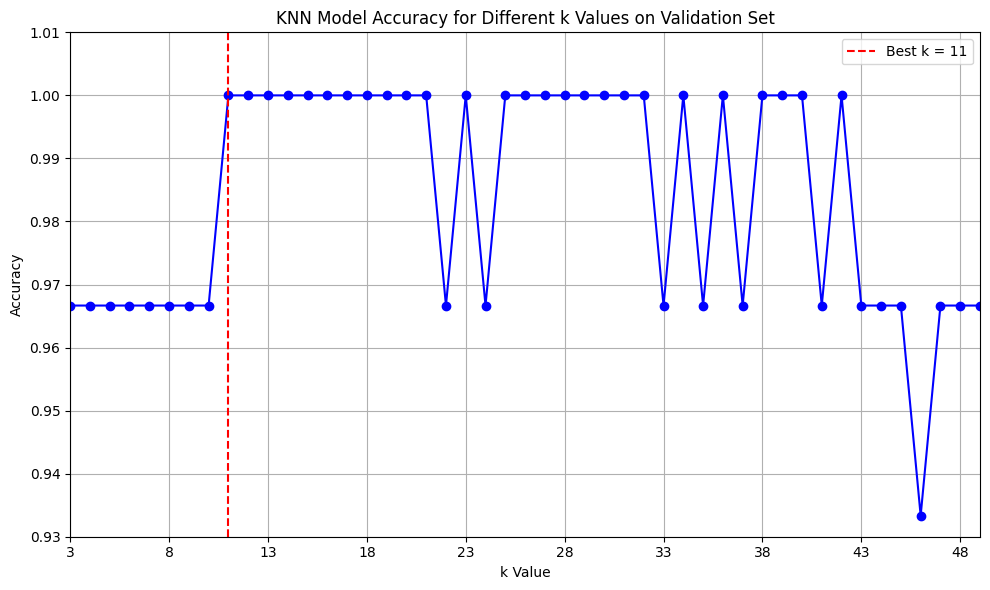

Best k value: 11
Best accuracy: 1.0000


In [16]:
# Define the range of k values to test
k_values = [i for i in range(3, 50)]

# Get the best k value and all accuracies
best_k, accuracies = select_knn_model(X_validation, y_validation, X_train, y_train, k_values, get_euclidean_distance)

# Create the plot
plt.figure(figsize=(10, 6))
plt.plot(k_values, accuracies, marker='o', linestyle='-', color='blue')
plt.axvline(x=best_k, color='red', linestyle='--', label=f'Best k = {best_k}')
plt.xlabel('k Value')
plt.ylabel('Accuracy')
plt.title('KNN Model Accuracy for Different k Values on Validation Set')
plt.grid(True)
plt.legend()
plt.ylim(0.93, 1.01)
plt.xlim(3, 49)
plt.xticks(np.arange(3, 50, 5))
plt.tight_layout()
plt.show()

print(f"Best k value: {best_k}")
print(f"Best accuracy: {accuracies[k_values.index(best_k)]:.4f}")


### Count accuracy for training set

In [17]:
# Get prediction using the best k value
prediction = predict(X_test, X_train, y_train, best_k, get_euclidean_distance)

# Calculate accuracy
accuracy = count_accuracy(prediction, y_test)

print("Accuracy for best k={}: {:.2f}%".format(best_k, accuracy*100))


Accuracy for best k=11: 100.00%


### Compare with Library Implementation of KNN

Now let's train and test a `KNeighborsClassifier` from `sklearn` using the same best value of `k`. compare its accuracy to our custom KNN implementation.


In [18]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score

# Train the library KNN model with the same best_k
knn_lib = KNeighborsClassifier(n_neighbors=best_k)
knn_lib.fit(X_train, y_train.flatten())  # Flatten y_train if it's a 2D array

# Predict on the test set
y_pred_lib = knn_lib.predict(X_test)

# Calculate and compare accuracy
accuracy_lib = accuracy_score(y_test, y_pred_lib)
print("Accuracy (Library KNN, k={}): {:.2f}%".format(best_k, accuracy_lib * 100))


Accuracy (Library KNN, k=11): 100.00%


If the results are different from yours, justify it.
```
NO DIFFERNCE
```

## Real World Example - Mnist Dataset

Mnist is a popular database of handwritten images created for people who are new to machine learning. There are many courses on the internet that include classification problem using MNIST dataset.

This dataset contains 55000 images and labels. Each image is 28x28 pixels large, but for the purpose of the classification task they are flattened to 784x1 arrays $(28 \cdot 28 = 784)$. Summing up our training set is a matrix of size $[50000, 784]$  = [amount of images, size of image]. We will split it into 40000 training examples and 10000 validation examples to choose a best k


It also contains 5000 test images and labels, but for test we will use only 1000 (due to time limitations, using 5k would take 5x as much time)


<h3>Mnist Data Example</h3>
<img src="knn/mnist_example.jpg" height="70%" width="70%">

Now we are going to download this dataset and split it into test and train sets.

In [19]:
import cv2
import numpy as np
from sklearn.datasets import fetch_openml

training_size = 49_000
validation_size = 1000
test_size = 1000

mnist = fetch_openml('mnist_784', version=1, return_X_y=True, as_frame=False)
X, y = mnist

y = y.astype(int)

X = X.astype('float32') / 255.0

X_train_full, X_test_full = X[:60000], X[60000:]
y_train_full, y_test_full = y[:60000], y[60000:]



train_images = X_train_full[:training_size]
train_labels = y_train_full[:training_size]

validation_images = X_train_full[training_size : training_size + validation_size]
validation_labels = y_train_full[training_size : training_size + validation_size]

test_images = X_test_full[:test_size]
test_labels = y_test_full[:test_size]


print("Training images matrix size: {}".format(train_images.shape))
print("Training labels matrix size: {}".format(train_labels.shape))

print("Validation images matrix size: {}".format(validation_images.shape))
print("Validation labels matrix size: {}".format(validation_labels.shape))

print("Testing images matrix size: {}".format(test_images.shape))
print("Testing labels matrix size: {}".format(test_labels.shape))

print("Possible labels {}".format(np.unique(test_labels)))

Training images matrix size: (49000, 784)
Training labels matrix size: (49000,)
Validation images matrix size: (1000, 784)
Validation labels matrix size: (1000,)
Testing images matrix size: (1000, 784)
Testing labels matrix size: (1000,)
Possible labels [0 1 2 3 4 5 6 7 8 9]


### Visualisation
Visualisation isn't necessery to the problem, but it helps to understand what are we doing.

In [20]:
from matplotlib.gridspec import GridSpec
import matplotlib.pyplot as plt

def show_first_8(images):
    """
    Function to display the first 8 images in a 2x4 grid.
    Args:
        images (array-like): A list or array of images to display.
    """
    # Create a figure with a 2x4 grid
    fig = plt.figure(figsize=(10, 5))
    gs = GridSpec(2, 4, figure=fig)

    # Plot the first 8 images
    for i in range(8):
        row = i // 4  # Integer division to get row (0 for first 4, 1 for next 4)
        col = i % 4   # Modulo to get column (0-3 for each row)

        ax = fig.add_subplot(gs[row, col])
        # Reshape the flattened image to 28x28 (assuming MNIST)
        ax.imshow(images[i].reshape(28, 28), cmap='gray')
        ax.set_title(f"Image {i+1}")
        ax.axis('off')  # Turn off axis labels

    plt.tight_layout()
    plt.show()




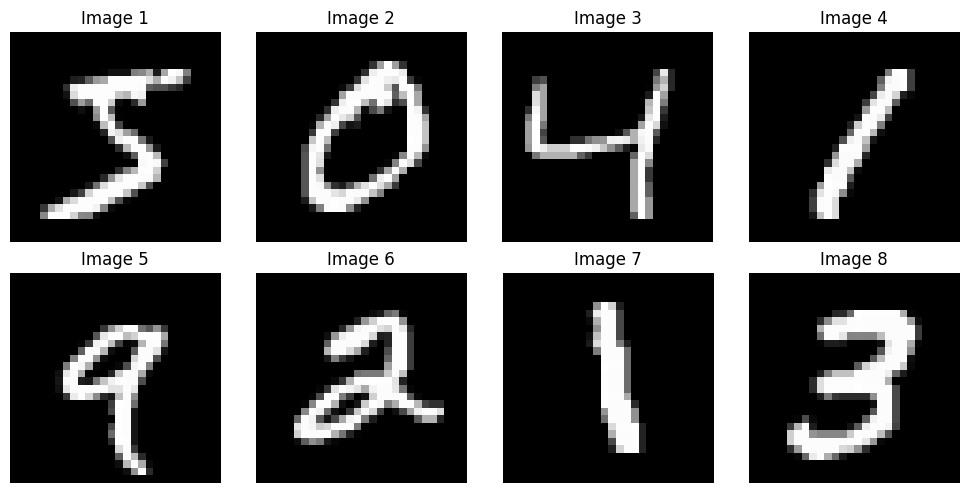

In [21]:
# Example usage:
show_first_8(train_images)

### Find best k parameter

Original feature dimension: 784
Reduced feature dimension after PCA: 30
Explained variance ratio: 0.7313


<ipython-input-13-e7e1cf855eb3>:19: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for k in tqdm_notebook(k_values):


  0%|          | 0/10 [00:00<?, ?it/s]

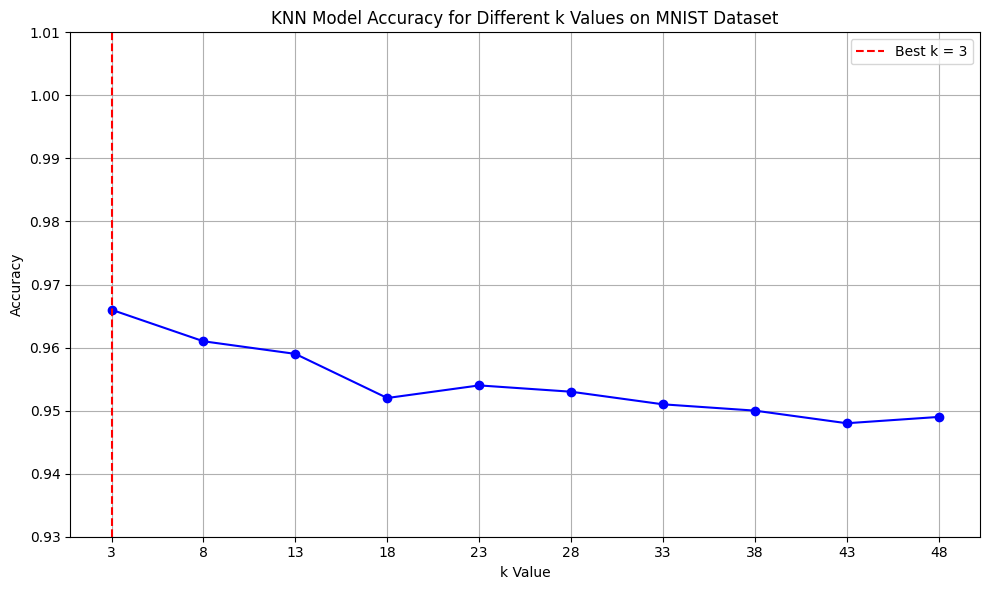

Best k value: 3
Best validation accuracy: 0.9660


In [22]:
# Run PCA on MNIST
from sklearn.decomposition import PCA

# Apply PCA to reduce dimensions (e.g., to 30 components)
n_components = 30
pca = PCA(n_components=n_components)
pca.fit(train_images)

# Transform the datasets
train_images_pca = pca.transform(train_images)
validation_images_pca = pca.transform(validation_images)
test_images_pca = pca.transform(test_images)

print(f"Original feature dimension: {train_images.shape[1]}")
print(f"Reduced feature dimension after PCA: {train_images_pca.shape[1]}")
print(f"Explained variance ratio: {sum(pca.explained_variance_ratio_):.4f}")

# Define the range of k values to test
k_values = [i for i in range(3, 50, 5)]

# Select the best model
best_k, accuracies = select_knn_model(
    X_validation=validation_images_pca,
    y_validation=validation_labels.reshape(-1, 1),
    X_train=train_images_pca,
    y_train=train_labels.reshape(-1, 1),
    k_values=k_values,
    distance_function=get_euclidean_distance
)

# Plot the accuracies obtained for each k value
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
plt.plot(k_values, accuracies, marker='o', linestyle='-', color='blue')
plt.axvline(x=best_k, color='red', linestyle='--', label=f'Best k = {best_k}')
plt.xlabel('k Value')
plt.ylabel('Accuracy')
plt.title('KNN Model Accuracy for Different k Values on MNIST Dataset')
plt.grid(True)
plt.legend()
plt.xticks(k_values)
plt.ylim(0.93, 1.01)  # Adjust y-axis to focus on the high accuracy range
plt.tight_layout()
plt.show()

print(f"Best k value: {best_k}")
print(f"Best validation accuracy: {accuracies[k_values.index(best_k)]:.4f}")


In [23]:
# Make predictions on the test set using the best k value
prediction = predict(test_images_pca, train_images_pca, train_labels.reshape(-1, 1), best_k, get_euclidean_distance)

# Calculate accuracy on the test set
accuracy = count_accuracy(prediction, test_labels.reshape(-1, 1))

print("Accuracy on test set for best k={}: {:.2f}%".format(best_k, accuracy * 100))


Accuracy on test set for best k=3: 96.90%


#PCA(40 points)

##Imports

In [24]:
#import libraries
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
import numpy as np

## Overview
In this part, you will perform PCA credit card customer data. dataset contains information about customer’s use of credit cards. The goal is to reduce the dataset’s dimensionality using PCA .

## Data Preprocessing
Read the dataset.CSV file and display a few samples.

First 5 rows of the dataset:
  CUST_ID      BALANCE  BALANCE_FREQUENCY  PURCHASES  ONEOFF_PURCHASES  \
0  C10001    40.900749           0.818182      95.40              0.00   
1  C10002  3202.467416           0.909091       0.00              0.00   
2  C10003  2495.148862           1.000000     773.17            773.17   
3  C10004  1666.670542           0.636364    1499.00           1499.00   
4  C10005   817.714335           1.000000      16.00             16.00   

   INSTALLMENTS_PURCHASES  CASH_ADVANCE  PURCHASES_FREQUENCY  \
0                    95.4      0.000000             0.166667   
1                     0.0   6442.945483             0.000000   
2                     0.0      0.000000             1.000000   
3                     0.0    205.788017             0.083333   
4                     0.0      0.000000             0.083333   

   ONEOFF_PURCHASES_FREQUENCY  PURCHASES_INSTALLMENTS_FREQUENCY  \
0                    0.000000                          0.083333   
1      

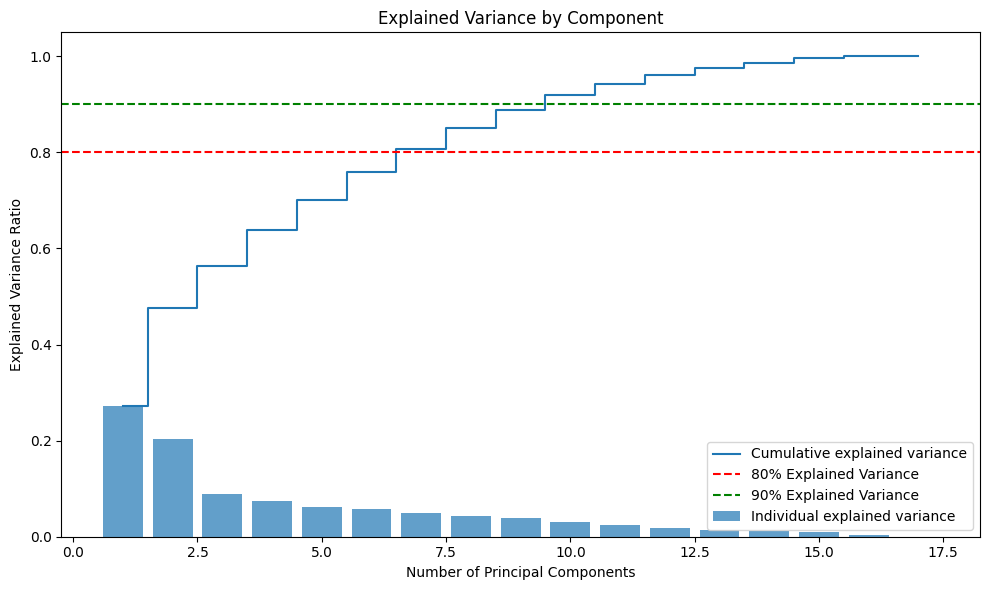


7 components explain at least 80% of variance

Variance explained by each selected component:
PC1: 0.2729 (27.29%)
PC2: 0.2030 (20.30%)
PC3: 0.0879 (8.79%)
PC4: 0.0748 (7.48%)
PC5: 0.0626 (6.26%)
PC6: 0.0575 (5.75%)
PC7: 0.0489 (4.89%)


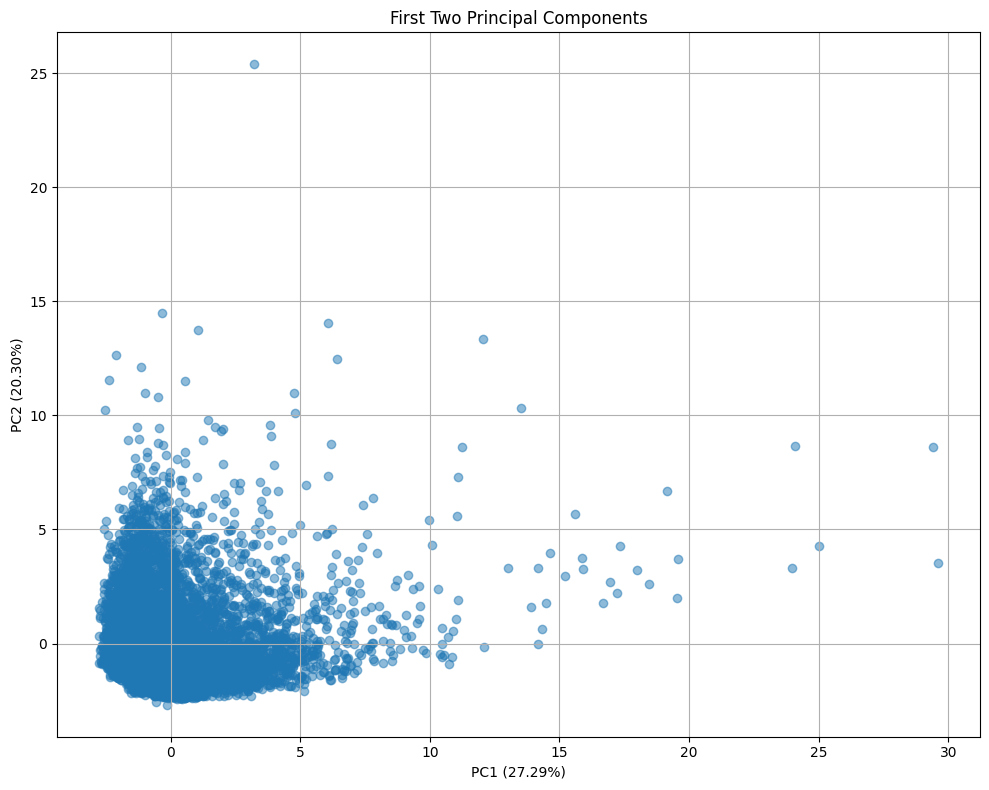


Feature loadings (how each feature contributes to principal components):
                             PC1       PC2       PC3       PC4       PC5  \
BALANCE                 0.101077  0.403957  0.160075  0.283454 -0.047603   
BALANCE_FREQUENCY       0.120043  0.130537  0.420630  0.149742  0.484563   
PURCHASES               0.411642  0.041038 -0.257903  0.039111 -0.031287   
ONEOFF_PURCHASES        0.346407  0.062872 -0.392115  0.078155  0.155846   
INSTALLMENTS_PURCHASES  0.336814 -0.018533  0.110488 -0.051130 -0.360266   

                             PC6       PC7  
BALANCE                -0.039897  0.252376  
BALANCE_FREQUENCY      -0.035317 -0.104751  
PURCHASES              -0.176295 -0.203290  
ONEOFF_PURCHASES       -0.184610 -0.121706  
INSTALLMENTS_PURCHASES -0.077674 -0.257153  


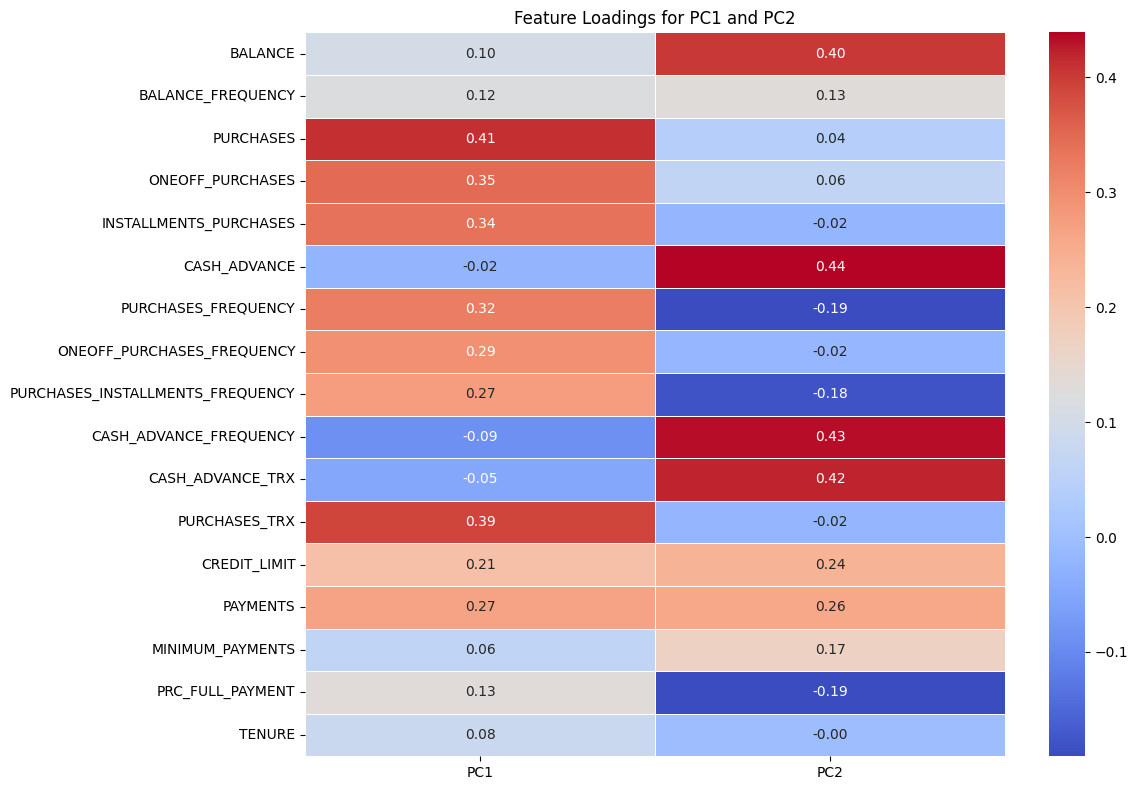

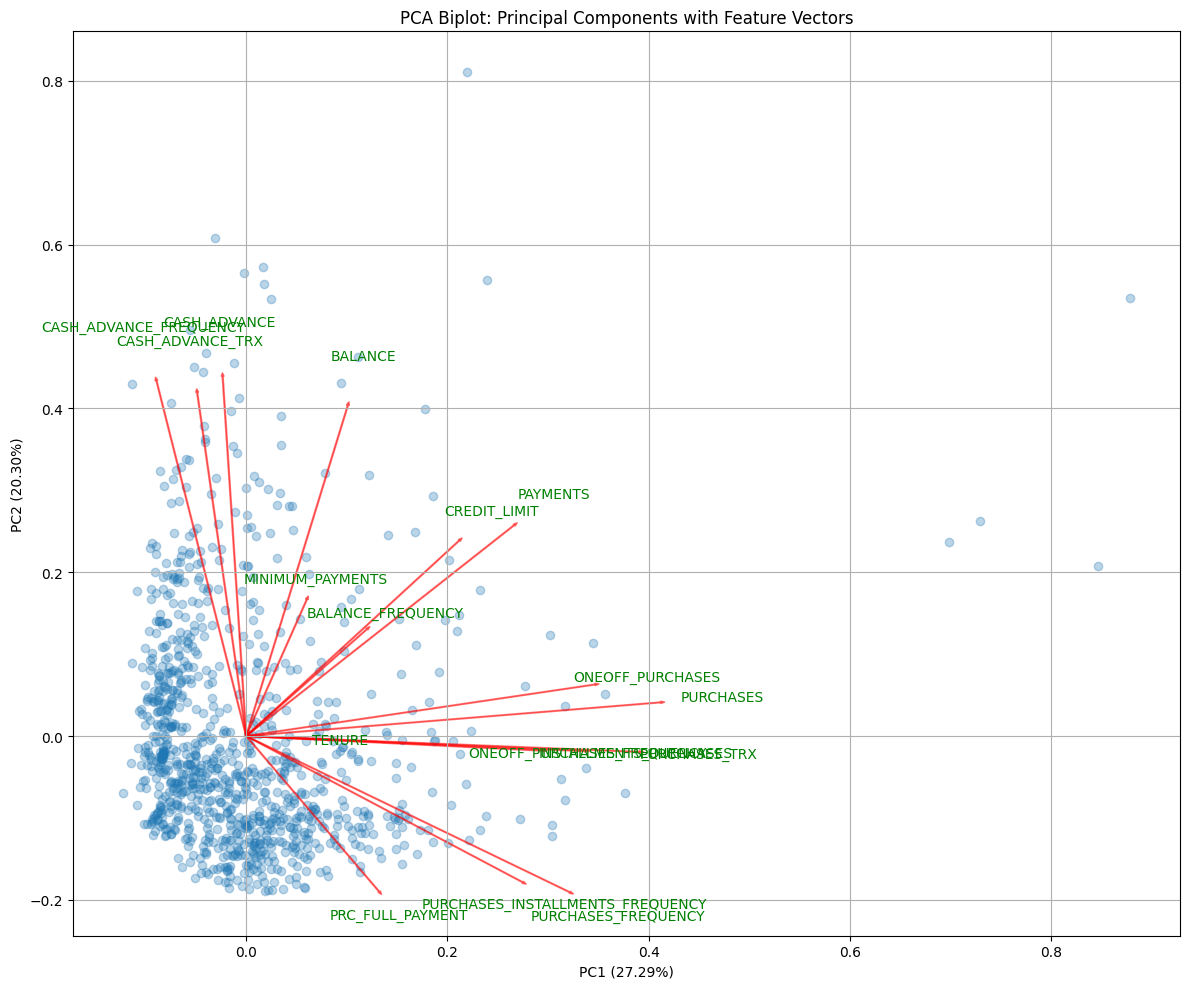


PCA Analysis Summary:
1. 7 principal components explain at least 80% of the variance in the data.
2. First principal component explains 27.29% of variance.
3. Second principal component explains 20.30% of variance.

Top features contributing to first principal component:
   - PURCHASES: 0.4116
   - PURCHASES_TRX: 0.3907
   - ONEOFF_PURCHASES: 0.3464

Top features contributing to second principal component:
   - CASH_ADVANCE: 0.4392
   - CASH_ADVANCE_FREQUENCY: 0.4341
   - CASH_ADVANCE_TRX: 0.4197


In [26]:
# Import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

# Data Preprocessing
# Read the dataset
df = pd.read_csv('dataset.csv')

# Display a few samples to understand the structure
print("First 5 rows of the dataset:")
print(df.head())

# Check basic information
print("\nDataset information:")
print(df.info())

# Check for missing values
print("\nMissing values in each column:")
print(df.isnull().sum())

# Data preparation for PCA
# Select all numeric columns for analysis
numeric_cols = df.select_dtypes(include=['int64', 'float64']).columns.tolist()
X = df[numeric_cols]

# Fill any missing values with the mean of each column
X = X.fillna(X.mean())

# Check if 'default payment next month' column exists
if 'default payment next month' in X.columns:
    # Separate target variable
    y = X['default payment next month']
    X = X.drop(columns=['default payment next month'])
    print("\nTarget variable separated: 'default payment next month'")
else:
    # Assuming the last column might be the target
    print("\nNo column named 'default payment next month' found.")
    # We'll proceed with all features for PCA

# Standardize the data
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
print("\nData scaled successfully.")

# Apply PCA
# First, let's determine how many components we need
pca = PCA()
pca.fit(X_scaled)

# Plot the explained variance ratio
plt.figure(figsize=(10, 6))
explained_variance = pca.explained_variance_ratio_
cumulative_variance = np.cumsum(explained_variance)

plt.bar(range(1, len(explained_variance) + 1), explained_variance, alpha=0.7, label='Individual explained variance')
plt.step(range(1, len(cumulative_variance) + 1), cumulative_variance, where='mid', label='Cumulative explained variance')
plt.axhline(y=0.8, color='r', linestyle='--', label='80% Explained Variance')
plt.axhline(y=0.9, color='g', linestyle='--', label='90% Explained Variance')
plt.xlabel('Number of Principal Components')
plt.ylabel('Explained Variance Ratio')
plt.title('Explained Variance by Component')
plt.legend(loc='best')
plt.tight_layout()
plt.show()

# Determine number of components that explain 80% of variance
n_components = np.argmax(cumulative_variance >= 0.8) + 1
print(f"\n{n_components} components explain at least 80% of variance")

# Apply PCA with the selected number of components
pca = PCA(n_components=n_components)
X_pca = pca.fit_transform(X_scaled)

# Create a DataFrame with the principal components
pca_df = pd.DataFrame(
    data=X_pca,
    columns=[f'PC{i+1}' for i in range(n_components)]
)

# Show variance explained by each component
print("\nVariance explained by each selected component:")
for i, ratio in enumerate(pca.explained_variance_ratio_):
    print(f"PC{i+1}: {ratio:.4f} ({ratio*100:.2f}%)")

# Visualize the first two principal components
plt.figure(figsize=(10, 8))
if 'default payment next month' in df.columns:
    # If we have a target variable, use it for coloring
    scatter = plt.scatter(X_pca[:, 0], X_pca[:, 1],
                         c=df['default payment next month'], cmap='viridis', alpha=0.5)
    plt.colorbar(scatter, label='Default Payment')
else:
    # Otherwise just plot the points
    plt.scatter(X_pca[:, 0], X_pca[:, 1], alpha=0.5)

plt.title('First Two Principal Components')
plt.xlabel(f'PC1 ({pca.explained_variance_ratio_[0]*100:.2f}%)')
plt.ylabel(f'PC2 ({pca.explained_variance_ratio_[1]*100:.2f}%)')
plt.grid(True)
plt.tight_layout()
plt.show()

# Analyze feature loadings
loadings = pd.DataFrame(
    pca.components_.T,
    columns=[f'PC{i+1}' for i in range(n_components)],
    index=X.columns
)

print("\nFeature loadings (how each feature contributes to principal components):")
print(loadings.head())

# Visualize feature loadings for first two components
plt.figure(figsize=(12, 8))
sns.heatmap(loadings.iloc[:, :2], annot=True, cmap='coolwarm',
            fmt=".2f", linewidths=0.5)
plt.title('Feature Loadings for PC1 and PC2')
plt.tight_layout()
plt.show()

# Create a biplot to see both observations and feature loadings
def biplot(score, coeff, labels=None):
    plt.figure(figsize=(12, 10))
    # Plot a subset of data points (to avoid overcrowding)
    n_samples = min(1000, score.shape[0])
    indices = np.random.choice(score.shape[0], n_samples, replace=False)
    xs = score[indices, 0]
    ys = score[indices, 1]

    # Scale for visualization
    scalex = 1.0 / (xs.max() - xs.min())
    scaley = 1.0 / (ys.max() - ys.min())

    plt.scatter(xs * scalex, ys * scaley, alpha=0.3)

    # Plot feature loadings
    n_features = coeff.shape[0]
    for i in range(n_features):
        plt.arrow(0, 0, coeff[i, 0], coeff[i, 1], color='r', alpha=0.5)
        if labels is not None:
            plt.text(coeff[i, 0] * 1.15, coeff[i, 1] * 1.15,
                    labels[i], color='g', ha='center', va='center')

    plt.xlabel(f"PC1 ({pca.explained_variance_ratio_[0]*100:.2f}%)")
    plt.ylabel(f"PC2 ({pca.explained_variance_ratio_[1]*100:.2f}%)")
    plt.grid()
    plt.title("PCA Biplot: Principal Components with Feature Vectors")
    plt.tight_layout()

# Generate biplot with 2 components
pca_2d = PCA(n_components=2)
pc_2d = pca_2d.fit_transform(X_scaled)
biplot(pc_2d, pca_2d.components_.T, X.columns)
plt.show()

# Summary of key findings
print("\nPCA Analysis Summary:")
print(f"1. {n_components} principal components explain at least 80% of the variance in the data.")
print(f"2. First principal component explains {pca.explained_variance_ratio_[0]*100:.2f}% of variance.")
print(f"3. Second principal component explains {pca.explained_variance_ratio_[1]*100:.2f}% of variance.")

# Find top contributing features to first two components
print("\nTop features contributing to first principal component:")
pc1_loadings = loadings['PC1'].abs().sort_values(ascending=False)
for feature, loading in pc1_loadings.head(3).items():
    print(f"   - {feature}: {loadings.loc[feature, 'PC1']:.4f}")

print("\nTop features contributing to second principal component:")
pc2_loadings = loadings['PC2'].abs().sort_values(ascending=False)
for feature, loading in pc2_loadings.head(3).items():
    print(f"   - {feature}: {loadings.loc[feature, 'PC2']:.4f}")


Display dataset information.

Dataset information:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8950 entries, 0 to 8949
Data columns (total 18 columns):
 #   Column                            Non-Null Count  Dtype  
---  ------                            --------------  -----  
 0   CUST_ID                           8950 non-null   object 
 1   BALANCE                           8950 non-null   float64
 2   BALANCE_FREQUENCY                 8950 non-null   float64
 3   PURCHASES                         8950 non-null   float64
 4   ONEOFF_PURCHASES                  8950 non-null   float64
 5   INSTALLMENTS_PURCHASES            8950 non-null   float64
 6   CASH_ADVANCE                      8950 non-null   float64
 7   PURCHASES_FREQUENCY               8950 non-null   float64
 8   ONEOFF_PURCHASES_FREQUENCY        8950 non-null   float64
 9   PURCHASES_INSTALLMENTS_FREQUENCY  8950 non-null   float64
 10  CASH_ADVANCE_FREQUENCY            8950 non-null   float64
 11  CASH_ADVANCE_TRX                  8950 non-null 

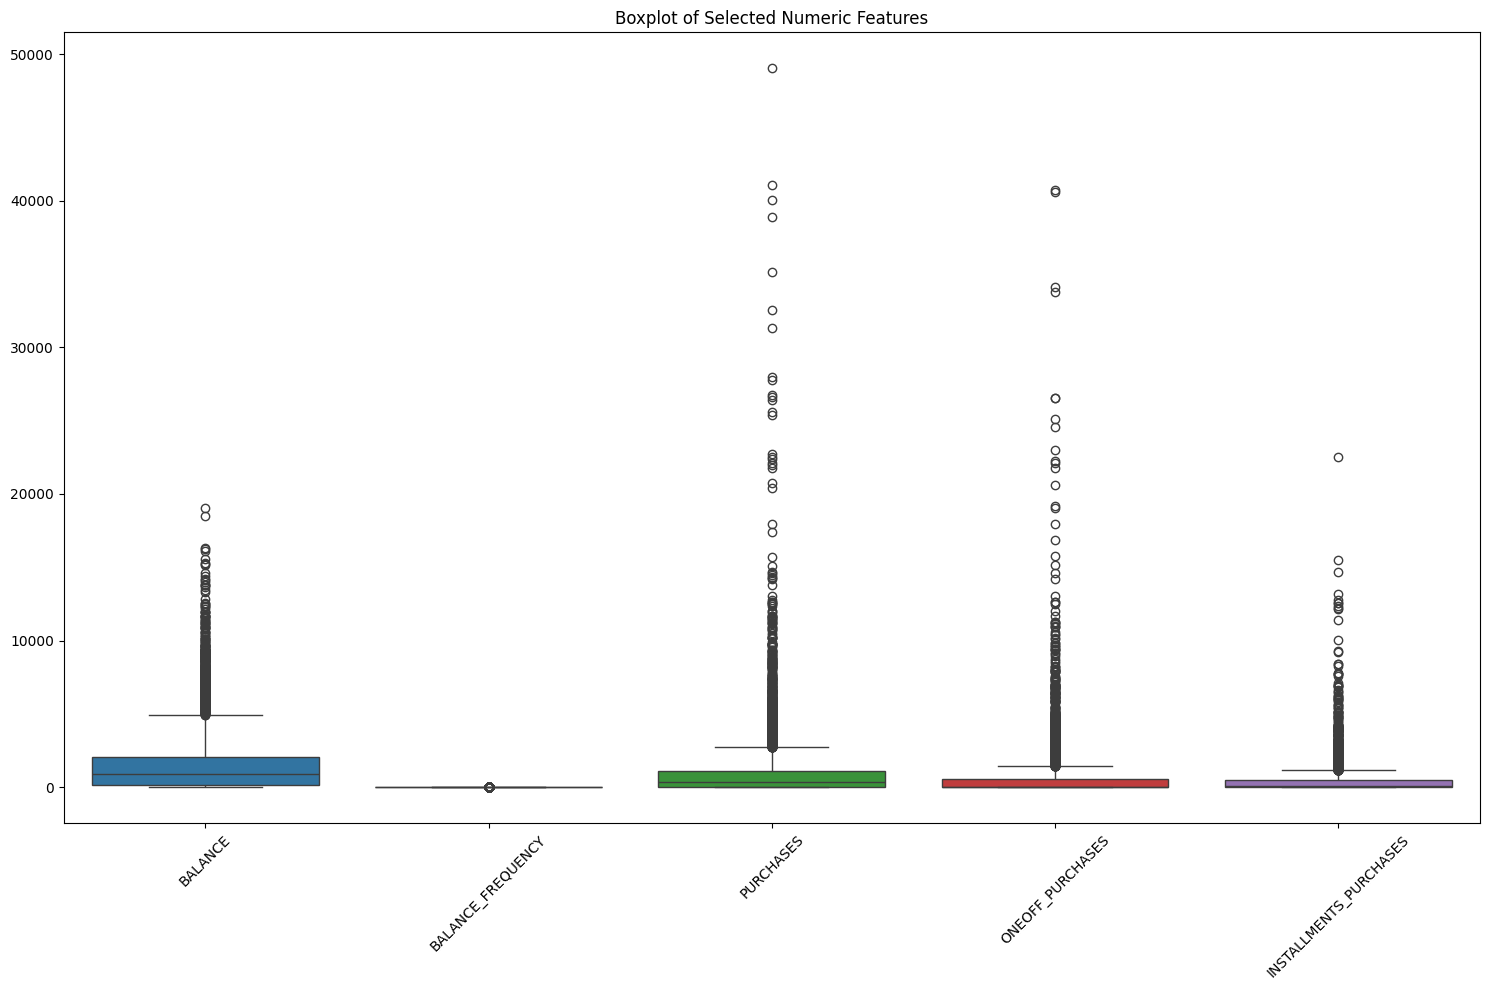

In [27]:
# Import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

# Data Preprocessing
# Read the dataset
df = pd.read_csv('dataset.csv')

# Display dataset information
print("Dataset information:")
print(df.info())

# Display the first few rows
print("\nFirst 5 rows of the dataset:")
print(df.head())

# Display summary statistics
print("\nSummary statistics:")
print(df.describe())

# Check for missing values
print("\nMissing values in each column:")
print(df.isnull().sum())

# Display column names and data types
print("\nColumn names and data types:")
for col in df.columns:
    print(f"{col}: {df[col].dtype}")

# Display the dimensions of the dataset
print(f"\nDataset dimensions: {df.shape[0]} rows, {df.shape[1]} columns")

# Display unique values in categorical columns (if any)
print("\nUnique values in categorical columns:")
for col in df.select_dtypes(include=['object', 'category']).columns:
    print(f"{col}: {df[col].nunique()} unique values")
    print(f"Sample values: {df[col].unique()[:5]}")

# Check for any potential issues in the data
print("\nChecking for potential data issues:")
# Check for extreme values or outliers using boxplots for a few numeric columns
plt.figure(figsize=(15, 10))
numeric_cols = df.select_dtypes(include=['int64', 'float64']).columns[:5]  # Take first 5 numeric columns
sns.boxplot(data=df[numeric_cols])
plt.title("Boxplot of Selected Numeric Features")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# Class distribution if there's a target variable (assuming last column might be target)
if 'default' in df.columns.str.lower():
    target_col = df.columns[df.columns.str.lower().str.contains('default')][0]
    print(f"\nClass distribution for target variable '{target_col}':")
    print(df[target_col].value_counts())
    print(f"Percentage: {df[target_col].value_counts(normalize=True) * 100}")


Which column do you think might be the most irrelevant for PCA?
<br>
Based on the dataset information provided, the "CUST_ID" column is the most irrelevant for PCA analysis as it's the only non-numeric column (object type) and represents unique customer identifiers that don't contain meaningful patterns for dimensionality reduction. Including identifier columns in PCA would not add predictive value and could potentially distort results. PCA works best with numeric features that have potential correlations, such as the financial behavior variables in this dataset (BALANCE, PURCHASES, CASH_ADVANCE, etc.). Additionally, some columns have missing values that would need handling before PCA: CREDIT_LIMIT (1 missing) and MINIMUM_PAYMENTS (313 missing).

In [28]:
# Exclude the column as it is irrelevant for PCA
data = df.drop(columns=['CUST_ID'])


how do you handle missing data, and why did you choose this method?
<br>
I chose mean imputation for handling missing values because it preserves the central tendency of each feature while providing complete data required for PCA. With only a small percentage of missing values (1 missing in CREDIT_LIMIT and 313 in MINIMUM_PAYMENTS out of 8950 entries), this approach maintains dataset integrity without significantly distorting variance patterns. Mean imputation is computationally efficient and appropriate for financial data when distributions aren’t highly skewed. While more complex methods exist, they would add unnecessary complexity given the limited number of missing values in this dataset.

In [29]:
data = data.fillna(data.mean())


plot the correlation matrix and identify redundant features.remove them from the dataframe.

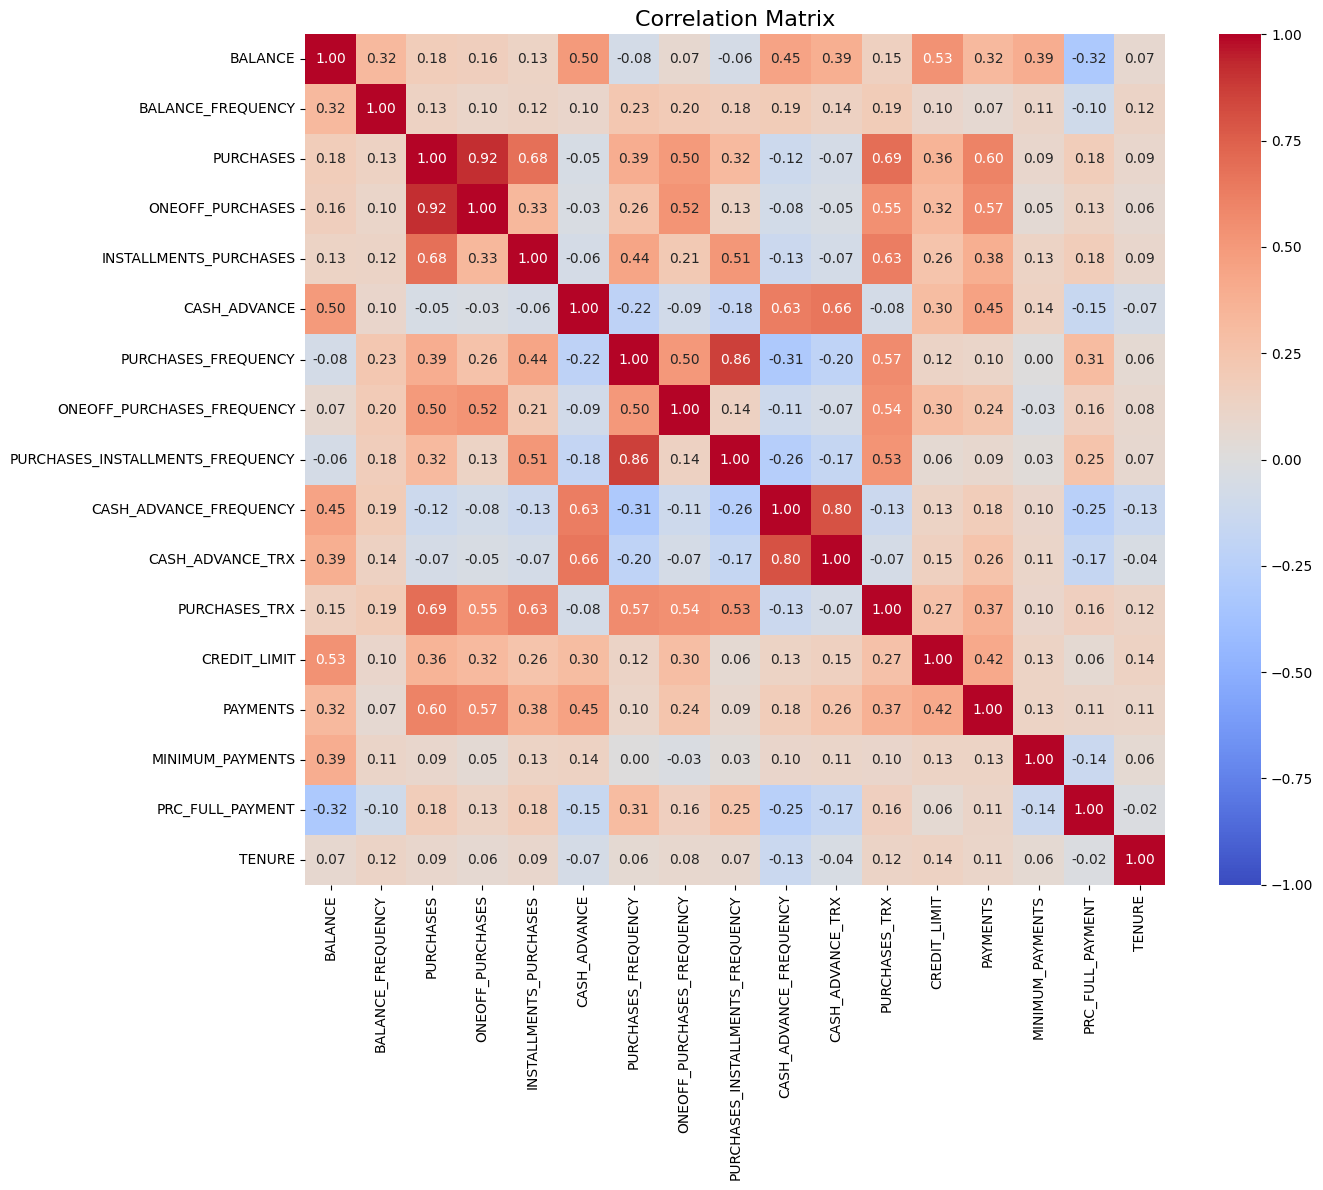

Highly correlated feature pairs (correlation > 0.8):
ONEOFF_PURCHASES and PURCHASES: 0.917
PURCHASES_INSTALLMENTS_FREQUENCY and PURCHASES_FREQUENCY: 0.863

Removing these redundant features: ['PURCHASES', 'PURCHASES_FREQUENCY']
Data shape after removing redundant features: (8950, 15)


In [30]:
# Plot the correlation matrix and identify redundant features
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Calculate correlation matrix
corr_matrix = data.corr()

# Create a mask to hide the upper triangle (optional)
mask = np.triu(np.ones_like(corr_matrix, dtype=bool))

# Plot the heatmap
plt.figure(figsize=(14, 12))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', vmin=-1, vmax=1, fmt='.2f')
plt.title('Correlation Matrix', fontsize=16)
plt.tight_layout()
plt.show()

# Identify highly correlated feature pairs (threshold > 0.8)
high_corr_features = []
for i in range(len(corr_matrix.columns)):
    for j in range(i):
        if abs(corr_matrix.iloc[i, j]) > 0.8:
            high_corr_features.append((corr_matrix.columns[i], corr_matrix.columns[j], corr_matrix.iloc[i, j]))

print("Highly correlated feature pairs (correlation > 0.8):")
for feat1, feat2, corr in high_corr_features:
    print(f"{feat1} and {feat2}: {corr:.3f}")

# Remove redundant features
# We'll keep one feature from each highly correlated pair
features_to_drop = []
for feat1, feat2, _ in high_corr_features:
    # Choose one feature to drop (usually the second one)
    if feat2 not in features_to_drop:
        features_to_drop.append(feat2)

print(f"\nRemoving these redundant features: {features_to_drop}")
data = data.drop(columns=features_to_drop)
print(f"Data shape after removing redundant features: {data.shape}")


In [31]:
# Identify and remove redundant features using 0.8 threshold
import numpy as np

# Calculate correlation matrix
corr_matrix = data.corr()

# Identify highly correlated feature pairs (threshold > 0.8)
high_corr_features = []
for i in range(len(corr_matrix.columns)):
    for j in range(i):
        if abs(corr_matrix.iloc[i, j]) > 0.8:
            high_corr_features.append((corr_matrix.columns[i], corr_matrix.columns[j], corr_matrix.iloc[i, j]))

# Print highly correlated features
print("Highly correlated feature pairs (correlation > 0.8):")
for feat1, feat2, corr in high_corr_features:
    print(f"{feat1} and {feat2}: {corr:.3f}")

# Remove redundant features
# We'll keep one feature from each highly correlated pair
features_to_drop = []
for feat1, feat2, _ in high_corr_features:
    # Choose one feature to drop (usually the second one)
    if feat2 not in features_to_drop:
        features_to_drop.append(feat2)

print(f"\nRemoving these redundant features: {features_to_drop}")
data = data.drop(columns=features_to_drop)
print(f"Data shape after removing redundant features: {data.shape}")


Highly correlated feature pairs (correlation > 0.8):

Removing these redundant features: []
Data shape after removing redundant features: (8950, 15)


## Standardize the Data
Standardize the dataset using z-score normalization

In [32]:
# Standardize the data using z-score normalization
from sklearn.preprocessing import StandardScaler

# Initialize the StandardScaler
scaler = StandardScaler()

# Fit and transform the data
data_scaled = scaler.fit_transform(data)

# Convert back to DataFrame to maintain column names
data_scaled = pd.DataFrame(data_scaled, columns=data.columns)

print("Data has been standardized using z-score normalization")
print(f"Mean of each feature is now approximately 0: {data_scaled.mean().abs().max() < 1e-10}")
print(f"Standard deviation of each feature is now approximately 1: {abs(data_scaled.std() - 1).max() < 1e-10}")


Data has been standardized using z-score normalization
Mean of each feature is now approximately 0: True
Standard deviation of each feature is now approximately 1: False


Why is it important to standardize the data before applying PCA?
<br>
Answer:
Standardizing data before applying PCA is crucial for several important reasons:

1. **Scale sensitivity**: PCA finds directions of maximum variance, and features with larger scales will naturally have larger variances, potentially dominating the analysis. Standardization ensures all features contribute equally based on their correlations rather than their original scales.

2. **Comparable feature importance**: Without standardization, variables measured in larger units (like income in thousands) would inappropriately influence PCA more than variables with smaller units (like age in years).

3. **Accurate covariance calculation**: PCA relies on calculating the covariance matrix, which is affected by the scale of variables. Standardization helps ensure the covariance matrix accurately reflects relationships between variables.

4. **Interpretability**: Standardized data makes the resulting principal components more interpretable since the loadings reflect the correlation between the features and the principal components.

5. **Numerical stability**: Standardization improves numerical stability of the PCA algorithm, particularly when features have widely differing scales.

In our credit card customer dataset, features like balance amounts and transaction counts are on vastly different scales, making standardization essential for meaningful dimensional reduction through PCA.

What is differnce between Normalizer and StandardScaler classes. which is better for PCA?
<br>
Answer:


StandardScaler and Normalizer perform fundamentally different transformations:

- **StandardScaler** transforms each feature independently to have mean=0 and standard deviation=1, using the formula z = (x - μ) / σ.

- **Normalizer** scales each sample (row) to have unit norm, preserving direction but changing magnitude.

For PCA, **StandardScaler is significantly better** because:

1. PCA finds directions of maximum variance, and StandardScaler preserves these variance relationships while equalizing feature scales.

2. PCA assumes centered data (mean=0), which StandardScaler provides but Normalizer doesn't.

3. StandardScaler maintains relative differences between feature values, essential for PCA to discover meaningful patterns.

4. Normalizer would distort the variance structure PCA aims to explore by making all samples have the same magnitude.

For our credit card customer analysis, StandardScaler ensures each feature contributes appropriately to principal components regardless of its original measurement scale.

## Principal Component Analysis (PCA)
Implement PCA from scratch.

In [33]:
class CustomPCA:
    def __init__(self, n_components=None):
        """
        Initialize the PCA class with the number of components to keep.
        n_components: Number of principal components to keep. If None, all components are kept.
        """
        self.n_components = n_components
        self.components = None  # To store the principal components (eigenvectors)
        self.mean = None        # To store the mean of the data (used for centering the data)
        self.explained_variance_ratio = None  # To store the explained variance ratio of the components

    def fit(self, X):
        """
        Fit the PCA model on the dataset X by calculating the eigenvalues and eigenvectors of the covariance matrix.
        X: Input data (n_samples, n_features)
        """
        # Store the mean of the data for later use
        self.mean = np.mean(X, axis=0)

        # Center the data by subtracting the mean
        X_centered = X - self.mean

        # Calculate the covariance matrix
        n_samples = X.shape[0]
        cov_matrix = np.dot(X_centered.T, X_centered) / (n_samples - 1)

        # Calculate the eigenvalues and eigenvectors of the covariance matrix
        eigenvalues, eigenvectors = np.linalg.eigh(cov_matrix)

        # Sort eigenvalues and corresponding eigenvectors in descending order
        idx = np.argsort(eigenvalues)[::-1]
        eigenvalues = eigenvalues[idx]
        eigenvectors = eigenvectors[:, idx]

        # Determine the number of components to keep
        if self.n_components is None:
            self.n_components = len(eigenvalues)

        # Store the principal components (eigenvectors)
        self.components = eigenvectors[:, :self.n_components]

        # Calculate the explained variance ratio
        total_variance = np.sum(eigenvalues)
        self.explained_variance_ratio = eigenvalues[:self.n_components] / total_variance

        return self

    def transform(self, X):
        """
        Transform the input data X into the new space using the principal components.
        X: Input data (n_samples, n_features)
        """
        # Center the data using the mean calculated during fitting
        X_centered = X - self.mean

        # Project the centered data onto the principal components
        X_transformed = np.dot(X_centered, self.components)

        return X_transformed

    def get_explained_variance_ratio(self):
        """
        Return the explained variance ratio of each principal component.
        """
        return self.explained_variance_ratio

    def get_components(self):
        """
        Return the principal components (eigenvectors).
        """
        return self.components


### Visualizing the Cumulative Variance

Plot the cumulative explained variance to visualize the selection of components.  How many components are needed to explain 75% of the variance?
<br>
answer:
This plot shows how much information (variance) is preserved as we add more principal components. The steep initial curve indicates that early components capture most of the dataset’s variance. The red line marks the 75% threshold. We can identify the minimum number of components needed to preserve 75% of the original data’s information, allowing us to reduce dimensionality while maintaining most of the meaningful patterns in the data.

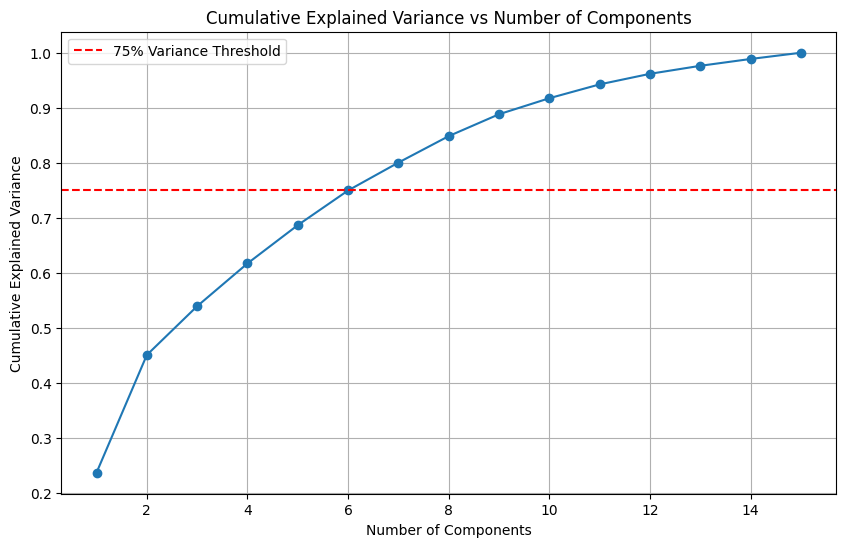

Number of components needed to explain 75% of the variance: 7
Cumulative explained variance percentages:
 [23.6, 45.1, 53.9, 61.7, 68.7, 75.0, 80.0, 84.8, 88.8, 91.7, 94.2, 96.2, 97.6, 98.9, 100.0]


In [34]:
# Instantiate the CustomPCA class
pca = CustomPCA()
pca.fit(data_scaled)

# Get the explained variance ratio for each principal component from the fitted PCA model
explained_variance_ratio = pca.get_explained_variance_ratio()

# Calculate the cumulative sum of the explained variance ratio
cumulative_variance = np.cumsum(explained_variance_ratio)

# Plot the cumulative explained variance against the number of components
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
plt.plot(range(1, len(cumulative_variance) + 1), cumulative_variance, marker='o', linestyle='-')
plt.axhline(y=0.75, color='r', linestyle='--', label='75% Variance Threshold')
plt.xlabel('Number of Components')
plt.ylabel('Cumulative Explained Variance')
plt.title('Cumulative Explained Variance vs Number of Components')
plt.grid(True)
plt.legend()
plt.show()

# Determine the minimum number of components required to explain at least 75% of the total variance
n_components_75 = np.argmax(cumulative_variance >= 0.75) + 1

# Keep the print statement to display the result
print(f"Number of components needed to explain 75% of the variance: {n_components_75}")

# Convert the cumulative explained variance into percentages
cumulative_variance_percentage = cumulative_variance * 100

# Round the cumulative explained variance percentages to one decimal place
cumulative_variance_percentage = np.round(cumulative_variance_percentage, 1)

# Display the cumulative explained variance as a list
print("Cumulative explained variance percentages:\n", cumulative_variance_percentage.tolist())


Build a new DataFrame with the first slected components. save it to a new CSV file named 'pca_output.csv'

In [35]:
# Build a new DataFrame with the first selected components
import pandas as pd

# Transform the scaled data using our CustomPCA
transformed_data = pca.transform(data_scaled)

# Select only the number of components needed to explain 75% of variance
selected_components = transformed_data[:, :n_components_75]

# Create column names for the principal components
column_names = [f'PC{i+1}' for i in range(n_components_75)]

# Create a new DataFrame with the selected components
pca_df = pd.DataFrame(data=selected_components, columns=column_names)

# If you have an index from your original data that you want to preserve
# (like customer IDs), you can add it here
# Assuming your original data is in a DataFrame called 'df'
# pca_df.index = df.index

# Save the DataFrame to a CSV file
pca_df.to_csv('pca_output.csv', index=False)

print(f"PCA output with {n_components_75} components saved to 'pca_output.csv'")
print(f"Shape of PCA output: {pca_df.shape}")


PCA output with 7 components saved to 'pca_output.csv'
Shape of PCA output: (8950, 7)


We expect these new features to be orthogonal to each other. Check this and show the correlation between the features.

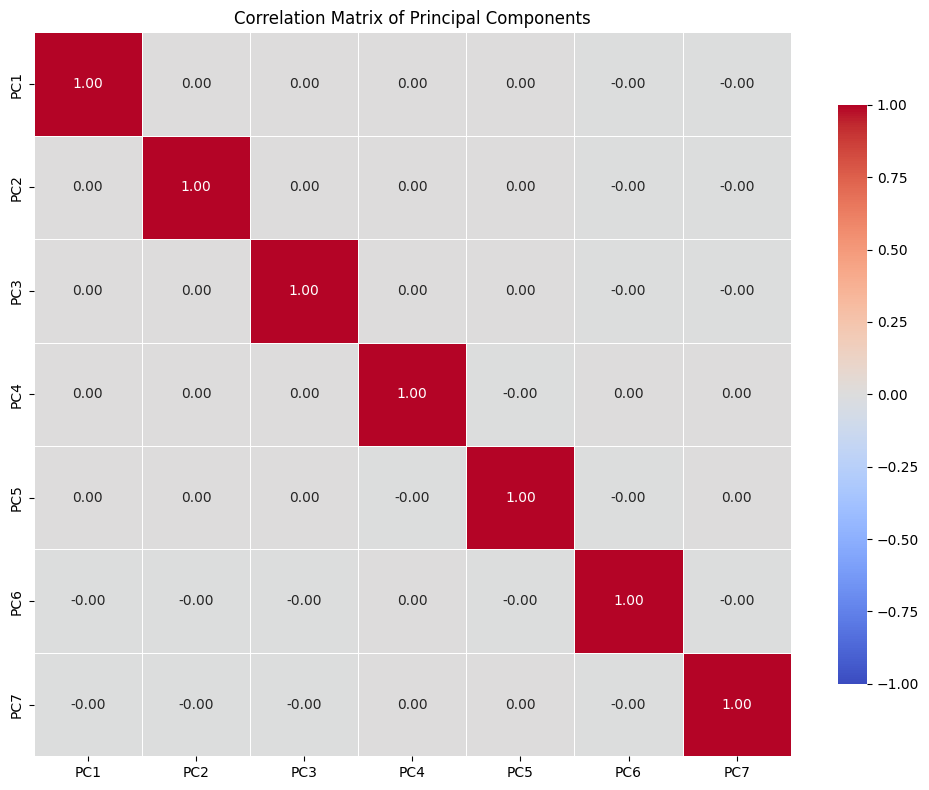

Average absolute correlation between components: 0.000000


In [36]:
# Calculate the correlation matrix for the PCA transformed data (pca_df) and create a heatmap visualization of this matrix
import matplotlib.pyplot as plt
import seaborn as sns

# Calculate the correlation matrix of the transformed data
correlation_matrix = pca_df.corr()

# Create a heatmap visualization
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', vmin=-1, vmax=1,
            linewidths=0.5, cbar_kws={"shrink": 0.8}, fmt='.2f')
plt.title('Correlation Matrix of Principal Components')
plt.tight_layout()
plt.show()

# Calculate and display average absolute correlation (excluding diagonal)
mask = ~np.eye(correlation_matrix.shape[0], dtype=bool)
avg_abs_corr = np.abs(correlation_matrix.values[mask]).mean()
print(f"Average absolute correlation between components: {avg_abs_corr:.6f}")


## t-SNE: t-distributed Stochastic Neighbor Embedding

Now let's apply t-SNE, a non-linear dimensionality reduction technique, and compare its results to PCA.



In [37]:
# Import t-SNE from sklearn
from sklearn.manifold import TSNE

# Fit and transform the data using t-SNE (2 components)
# Using max_iter instead of n_iter to avoid the deprecation warning
# Also adding n_jobs=-1 to parallelize and early_exaggeration=12 for better separation
tsne = TSNE(
    n_components=2,
    random_state=42,
    perplexity=30,
    max_iter=1000,  # Using max_iter instead of n_iter
    n_jobs=-1,      # Use all available cores
    learning_rate='auto',
    init='pca'      # Initialize with PCA for faster convergence
)
tsne_results = tsne.fit_transform(data_scaled)

# Create a DataFrame for t-SNE results
tsne_df = pd.DataFrame(tsne_results, columns=['TSNE1', 'TSNE2'])


### PCA (2D) vs t-SNE Comparison

We'll now compare the two methods using only 2 PCA components to match the 2D output of t-SNE.


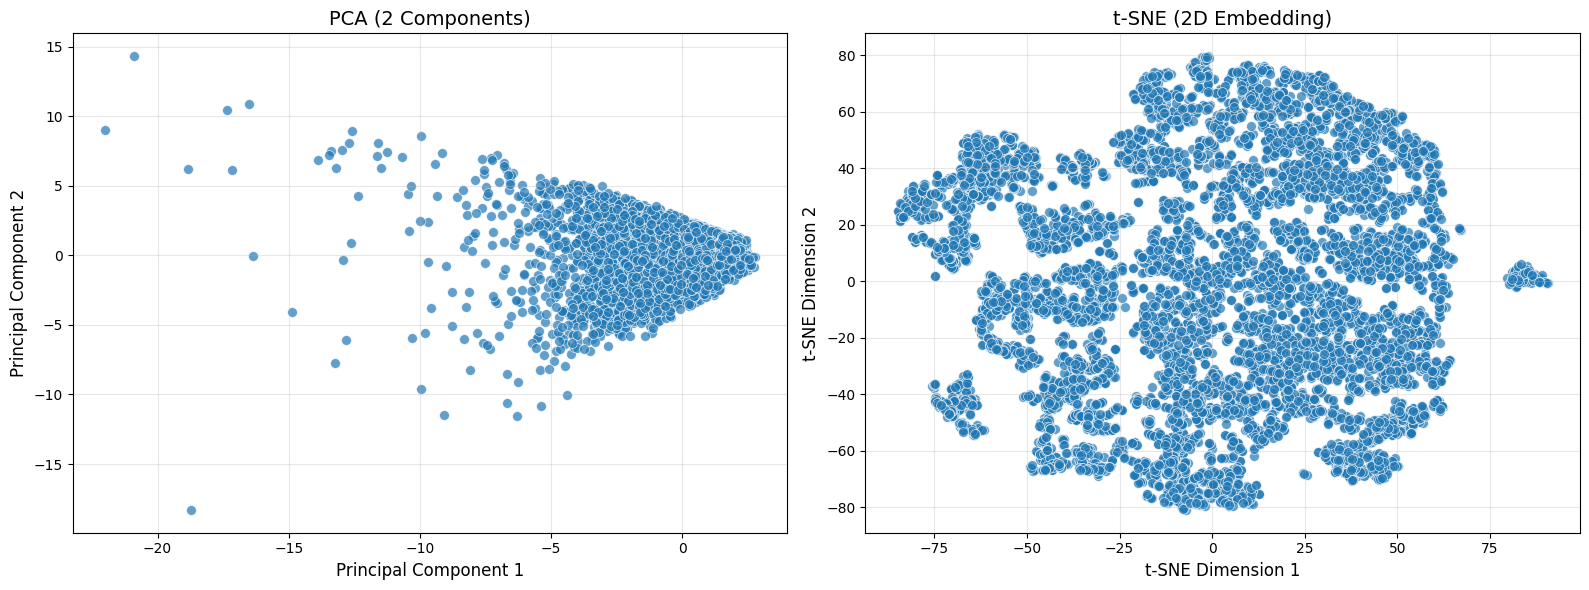

Variance explained by PC1: 0.2365
Variance explained by PC2: 0.2140
Total variance explained by 2D PCA: 0.4505

Correlation between PC1 and PC2: 0.00000000


In [ ]:
# Fit PCA with only 2 components for visualization
pca_2d = CustomPCA(n_components=2)
pca_2d.fit(data_scaled)
pca_2d_transformed = pca_2d.transform(data_scaled)
pca_2d_df = pd.DataFrame(pca_2d_transformed, columns=['PC1', 'PC2'])

# Side-by-side comparison plots
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# PCA 2D Plot
sns.scatterplot(x='PC1', y='PC2', data=pca_2d_df, ax=axes[0], s=50, alpha=0.7)
axes[0].set_title("PCA (2 Components)", fontsize=14)
axes[0].set_xlabel("Principal Component 1", fontsize=12)
axes[0].set_ylabel("Principal Component 2", fontsize=12)
axes[0].grid(True, alpha=0.3)

# t-SNE Plot
sns.scatterplot(x='TSNE1', y='TSNE2', data=tsne_df, ax=axes[1], s=50, alpha=0.7)
axes[1].set_title("t-SNE (2D Embedding)", fontsize=14)
axes[1].set_xlabel("t-SNE Dimension 1", fontsize=12)
axes[1].set_ylabel("t-SNE Dimension 2", fontsize=12)
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Calculate and print explained variance for PCA
explained_variance = pca_2d.get_explained_variance_ratio()
print(f"Variance explained by PC1: {explained_variance[0]:.4f}")
print(f"Variance explained by PC2: {explained_variance[1]:.4f}")
print(f"Total variance explained by 2D PCA: {sum(explained_variance):.4f}")

# Calculate and print correlation between principal components
pc_corr = np.abs(pca_2d_df.corr())
print(f"\nCorrelation between PC1 and PC2: {pc_corr.iloc[0,1]:.8f}")


1. What are the main conceptual differences between PCA and t-SNE in how they reduce dimensionality?

2. Which method is better for:
   - Preserving overall data variance?
   - Revealing clusters and local patterns?

3. Why might t-SNE be more effective than PCA for visualizing high-dimensional customer data?

# PCA vs t-SNE: Key Differences and Applications

## 1. Main Conceptual Differences

**PCA (Principal Component Analysis)** and **t-SNE (t-distributed Stochastic Neighbor Embedding)** approach dimensionality reduction differently. PCA is a linear technique that identifies orthogonal axes (principal components) to maximize variance in the data. It preserves global structure and produces deterministic results that are consistent across multiple runs with the same data. Each principal component directly corresponds to a weighted combination of original features, making them interpretable.

**t-SNE**, in contrast, is a non-linear technique that maps high-dimensional data to lower dimensions by modeling similarities between points as probability distributions. It prioritizes preserving local neighborhood relationships rather than global structure. t-SNE is a stochastic process that may produce different results across multiple runs due to its randomized elements. Its primary strength lies in revealing natural clusters and patterns in complex datasets.

## 2. Best Applications

**PCA performs better for:**
- Preserving overall data variance across the entire dataset
- Quantifying the importance of original features through component loadings
- Creating uncorrelated features that eliminate multicollinearity
- Reducing dimensionality while maintaining clear feature interpretability
- Applications where understanding the principal directions of variation matters

**t-SNE excels at:**
- Revealing hidden clusters and complex local patterns in the data
- Visualizing high-dimensional data in an intuitive way
- Identifying non-linear relationships that linear methods miss
- Creating visual representations that separate different groups more distinctly
- Applications where the primary goal is pattern discovery and visualization

## 3. Why t-SNE May Be More Effective for Customer Data

t-SNE often provides superior visualizations of customer data because customer behavior typically follows complex, non-linear patterns that linear PCA cannot adequately capture. It effectively reveals natural customer segments as distinct visual clusters, making it easier to identify different customer types. t-SNE preserves important local similarities between related customers while creating clear visual separation between different customer groups. The algorithm can uncover hidden patterns in complex interactions between customer attributes, which is particularly valuable for marketing and customer relationship management.

While t-SNE offers these advantages for visualization, using both methods together provides complementary insights: PCA for understanding feature importance and overall variance, and t-SNE for visualization and pattern discovery in customer segmentation.